In [2]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.3 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 2

In [2]:
!pip install gradio

  Using cached gradio-4.37.2-py3-none-any.whl (12.3 MB)
  Using cached aiofiles-23.2.1-py3-none-any.whl (15 kB)
  Using cached fastapi-0.111.0-py3-none-any.whl (91 kB)
  Using cached ffmpy-0.3.2.tar.gz (5.5 kB)
  Preparing metadata (setup.py) ... done
  Using cached gradio_client-1.0.2-py3-none-any.whl (318 kB)
  Using cached httpx-0.27.0-py3-none-any.whl (75 kB)
  Using cached orjson-3.10.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (144 kB)
  Using cached pydub-0.25.1-py2.py3-none-any.whl (32 kB)
  Using cached python_multipart-0.0.9-py3-none-any.whl (22 kB)
  Using cached ruff-0.5.0-py3-none-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.1 MB)
  Using cached semantic_version-2.10.0-py2.py3-none-any.whl (15 kB)
  Using cached tomlkit-0.12.0-py3-none-any.whl (37 kB)
  Using cached uvicorn-0.30.1-py3-none-any.whl (62 kB)
  Using cached websockets-11.0.3-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (129 kB)
  Using

In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
import os
import re
import torch
from bs4 import BeautifulSoup
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW, get_scheduler
from torch.utils.data import DataLoader
import datasets
from datasets import Dataset, DatasetDict
from tqdm import tqdm
import matplotlib.pyplot as plt
import json
import gradio as gr

# Load Roberta tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)

# Load data
df_train = pd.read_csv('/content/drive/MyDrive/train.csv')
df_valid = pd.read_csv('/content/drive/MyDrive/valid.csv')

# Preprocess data
df_train = df_train.filter(['Title', 'Body', 'Tags', 'Y'])
df_train['Y'] = df_train['Y'].map({'LQ_CLOSE':0, 'LQ_EDIT': 1, 'HQ':2})

df_valid = df_valid.filter(['Title', 'Body', 'Tags', 'Y'])
df_valid['Y'] = df_valid['Y'].map({'LQ_CLOSE':0, 'LQ_EDIT': 1, 'HQ':2})

class Preprocessing:
    def __get_body_tag_text(self, text):
        soup = BeautifulSoup(text, features='xml')
        return soup.get_text()

    def __lower_and_punc_removal(self, text):
        text = text.lower()
        text = re.sub(r'[^(a-zA-Z)\s]', '', text)
        return text

    def __init__(self, df):
        self.df = df
        self.df['Body_Between_Tags'] = self.df['Body'].apply(self.__get_body_tag_text)
        self.df['Final_clean'] = self.df['Body_Between_Tags'].apply(self.__lower_and_punc_removal)

PreprocessedObject_train = Preprocessing(df=df_train)
PreprocessedObject_valid = Preprocessing(df=df_valid)

PreprocessedObject_train.df.dropna(inplace=True)
PreprocessedObject_valid.df.dropna(inplace=True)
PreprocessedObject_train.df.reset_index(inplace=True)
PreprocessedObject_valid.df.reset_index(inplace=True)

df_train_final = PreprocessedObject_train.df
df_valid_final = PreprocessedObject_valid.df

df_train_final.drop(['index', 'Tags', 'Body', 'Title'], inplace=True, axis=1)
df_valid_final.drop(['index', 'Tags', 'Body', 'Title'], inplace=True, axis=1)

# Retain the label column
df_train_final = df_train_final[['Final_clean', 'Y']]
df_valid_final = df_valid_final[['Final_clean', 'Y']]

# Create DatasetDict
datasets_train_test = DatasetDict({
    "train": Dataset.from_pandas(df_train_final),
    "test": Dataset.from_pandas(df_valid_final)
})

# Tokenize datasets
def tokenize_function(examples):
    return tokenizer(examples["Final_clean"], padding="max_length", truncation=True)

tokenized_datasets = datasets_train_test.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['Final_clean'])
tokenized_datasets = tokenized_datasets.rename_column("Y", "labels")
tokenized_datasets.set_format("torch")

# Create dataloaders
train_dataloader = DataLoader(tokenized_datasets["train"], shuffle=True, batch_size=8)
eval_dataloader = DataLoader(tokenized_datasets["test"], batch_size=8)

# Define optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 1
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# Move model to appropriate device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# Training loop
progress_bar = tqdm(range(num_training_steps))
model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        if batch is not None and isinstance(batch, dict) and all(v is not None for v in batch.values()):  # Check if batch is not None and contains valid data
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()

            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            progress_bar.update(1)
        else:
            print("Warning: Empty or invalid batch encountered.")

# Evaluation
correct = 0
total = 0
model.eval()

for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    correct += torch.sum(predictions == batch["labels"]).item()
    total += len(predictions)

accuracy = correct / total
print("Accuracy:", accuracy)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-3-931cb63da742>:34: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, features='xml')
<ipython-input-3-931cb63da742>:34: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, features='xml')


Map:   0%|          | 0/45000 [00:00<?, ? examples/s]

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 5625/5625 [1:06:22<00:00,  1.41it/s]

Accuracy: 0.8691333333333333


ModuleNotFoundError: No module named 'evaluate'

In [4]:
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.3 MB/s eta 0:00:00


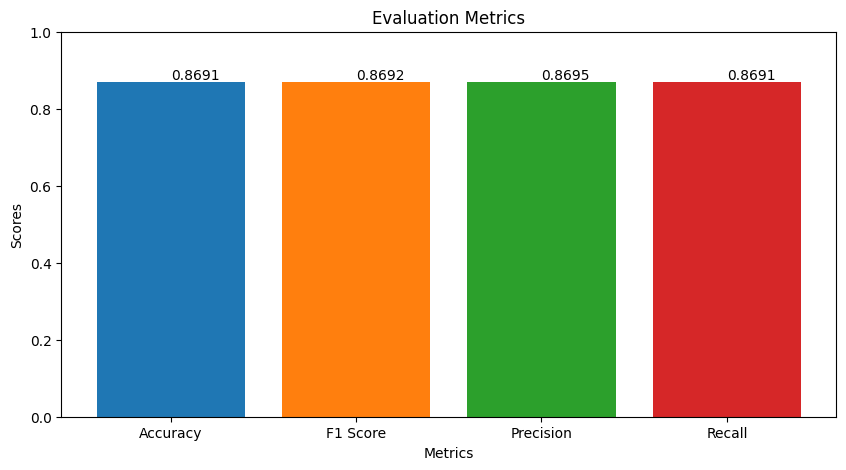

In [5]:
# Load evaluation metrics
import evaluate
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")

# Evaluate the model on the evaluation dataset
model.eval()
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)

    # Add batch results to the metrics
    accuracy_metric.add_batch(predictions=predictions, references=batch["labels"])
    f1_metric.add_batch(predictions=predictions, references=batch["labels"])
    precision_metric.add_batch(predictions=predictions, references=batch["labels"])
    recall_metric.add_batch(predictions=predictions, references=batch["labels"])

# Compute the metrics
accuracy = accuracy_metric.compute()['accuracy']
f1 = f1_metric.compute(average='weighted')['f1']
precision = precision_metric.compute(average='weighted')['precision']
recall = recall_metric.compute(average='weighted')['recall']

# Store the metrics in a dictionary for easy plotting
metrics = {
    'Accuracy': accuracy,
    'F1 Score': f1,
    'Precision': precision,
    'Recall': recall
}

# Colors for the bars
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # You can customize these colors

# Plot the metrics as a bar chart
plt.figure(figsize=(10, 5))
bars = plt.bar(metrics.keys(), metrics.values(), color=colors)
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Evaluation Metrics')
plt.ylim(0, 1)  # Assuming metrics are between 0 and 1

# Add values on top of the bars for better visualization
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), va='bottom')  # va: vertical alignment

plt.show()

# Save metrics to a CSV file
metrics_data = {
    'Metric': ['Accuracy', 'F1 Score', 'Precision', 'Recall'],
    'Score': [accuracy, f1, precision, recall]
}

metrics_df = pd.DataFrame(metrics_data)
metrics_df.to_csv('/content/drive/MyDrive/metrics_roberta.csv', index=False)

# Save the metrics to a file
metrics_filename = '/content/drive/My Drive/metrics_roberta.json'  # Change the filename for each model
with open(metrics_filename, 'w') as f:
    json.dump(metrics, f)

# Save the model to a file
model_path = '/content/drive/My Drive/trained_model_roberta.pth'
torch.save(model.state_dict(), model_path)


In [6]:
import torch
from transformers import RobertaForSequenceClassification, RobertaTokenizer
import gradio as gr

# Load the model and tokenizer for Roberta
model_path = '/content/drive/MyDrive/trained_model_roberta.pth'
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)
model.load_state_dict(torch.load(model_path))
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Mapping from numerical predictions to original labels
label_map = {0: 'LQ_CLOSE', 1: 'LQ_EDIT', 2: 'HQ'}

def classify_text(text):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=-1).item()
    return label_map[predicted_class]

# Create Gradio interface
iface = gr.Interface(
    fn=classify_text,
    inputs=gr.Textbox(lines=2, label="Enter text to classify"),
    outputs=gr.Label(num_top_classes=3),
    title="Roberta Text Classification",
    description="Enter text and classify its category using a fine-tuned Roberta model."
)

# Launch the interface
iface.launch()


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://f3d553bc501f4215f6.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
